In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
import logging as log
from torchvision import transforms, datasets
BATCH_SIZE = 100
DATASET = 500

# DATASET

In [43]:
class GaussianDataset(torch.utils.data.Dataset):
    def __init__(self,ids,labels):
        self.ids = ids
        self.labels = labels
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self,index):
        Id = self.ids[index]
        X = torch.load('data/' + str(Id)+'.pt')
        y = self.labels[Id]
        
        return X,y

In [44]:
ids = np.arange(1,DATASET + 1,1)
labels = np.full(DATASET,1) #simply labels
labels = dict([(x,y) for x,y in zip(ids,labels)]) # id to label mapping
training = GaussianDataset(ids,labels)

In [47]:
training_gen = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
num_batches = len(training_gen)

# NETWORKS

In [48]:
class Discriminator(torch.nn.Module):
    '''
    Single hidden layer discriminator network
    '''
    def __init__(self):
        super(Discriminator,self).__init__()
        n_features = 2
        n_hidden1 = 10
        n_out = 1
        
        self.hidden = nn.Sequential(nn.Linear(n_features,n_hidden1),nn.LeakyReLU(0.2),nn.Dropout(0.3))
        self.out = nn.Sequential(nn.Linear(n_hidden1,n_out),nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden(x)
        x = self.out(x)
        return x

In [49]:
class Generator(torch.nn.Module):
    '''
    Single hidden layer generator network
    '''
    def __init__(self):
        super(Generator,self).__init__()
        n_features = 2
        n_hidden1 = 10
        n_hidden2 = 10
        n_out = 2
        
        self.hidden1 = nn.Sequential(nn.Linear(n_features,n_hidden1),nn.LeakyReLU(0.2))
        self.hidden2 = nn.Sequential(nn.Linear(n_hidden1,n_hidden2),nn.LeakyReLU(0.2))
        self.out = nn.Sequential(nn.Linear(n_hidden2,n_out),nn.Sigmoid())
        
    def forward(self,x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

In [81]:
disc = Discriminator()
gen = Generator()

if torch.cuda.is_available():
    disc.cuda()
    gen.cuda()

# Optimizer

In [93]:
d_opt = optim.Adam(disc.parameters(), lr = 0.0002)
g_opt = optim.Adam(gen.parameters(), lr = 0.0002)

loss = nn.BCELoss()

# CREATING LABELS FOR TRAINING

In [83]:
def real_data_target(size):
    o = torch.ones(size,1,dtype = torch.float32,requires_grad=False)
    if torch.cuda.is_available():
        return o.cuda()
    return o

def fake_data_target(size):
    z = torch.zeros(size,1,dtype = torch.float32, requires_grad=False)
    if torch.cuda.is_available():
        return z.cuda()
    return z

In [84]:
def noise(size):
    n =  torch.randn(size,2,dtype = torch.float32,requires_grad=False)
    if torch.cuda.is_available(): return n.cuda()
    return n

# TRAINING

In [85]:
def train_d(optimizer, real_data, fake_data):
    #set optimizer gradients to zero to store fresh gradients
    optimizer.zero_grad()
    
    prediction_real = disc(real_data.float())
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    
    prediction_fake = disc(fake_data)    
    error_fake = loss(prediction_fake, fake_data_target(fake_data.size(0)))
    
    total_error = (error_real + error_fake)/2
    total_error.backward()
    optimizer.step() #update weights
    
    return (error_real + error_fake)/2, prediction_real, prediction_fake    

def train_g(optimizer, fake_data):
    optimizer.zero_grad()
    
    prediction = disc(fake_data.float())
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    optimizer.step()
    return error

In [86]:
#number of steps to train discriminator
EPOCHS = 500
BATCHES = DATASET/BATCH_SIZE

In [87]:
d_errors = []
g_errors = []

In [106]:
for epoch in range(EPOCHS):
    g_err_avg = 0
    d_err_avg = 0
    for n_batch,(real_batch,_) in enumerate(training_gen):
        #generate noise data
        noise_data = noise(real_batch.size(0)).float()
        fake_data = gen(noise_data).float()
        
        #Train discriminator
        real_data = real_batch
        if torch.cuda.is_available(): 
            real_data = real_data.cuda()
        
        d_error, d_predr, d_predf = train_d(d_opt,real_data,fake_data.detach())
        d_err_avg+=d_error
        
        #Train generator
        g_error = train_g(g_opt,fake_data)
        g_err_avg+=g_error
        
    d_errors.append(d_err_avg/BATCHES)
    g_errors.append(g_err_avg/BATCHES)
    if epoch%20==0:
        print("Epoch no : {} Discriminator error: {}   Generator error: {}".format(epoch,d_err_avg/BATCHES,g_err_avg/BATCHES))

Epoch no : 0 Discriminator error: 0.6944591999053955   Generator error: 0.6944884657859802
Epoch no : 20 Discriminator error: 0.695958137512207   Generator error: 0.6915001273155212
Epoch no : 40 Discriminator error: 0.6947196125984192   Generator error: 0.6903315186500549
Epoch no : 60 Discriminator error: 0.6931368112564087   Generator error: 0.6911644339561462
Epoch no : 80 Discriminator error: 0.694516122341156   Generator error: 0.6915886998176575
Epoch no : 100 Discriminator error: 0.6946298480033875   Generator error: 0.6924841403961182
Epoch no : 120 Discriminator error: 0.6946742534637451   Generator error: 0.6936087012290955
Epoch no : 140 Discriminator error: 0.6940385699272156   Generator error: 0.6939820647239685
Epoch no : 160 Discriminator error: 0.6915376782417297   Generator error: 0.6946877837181091
Epoch no : 180 Discriminator error: 0.694438636302948   Generator error: 0.693474531173706
Epoch no : 200 Discriminator error: 0.6941689848899841   Generator error: 0.6904

# PLOTTING

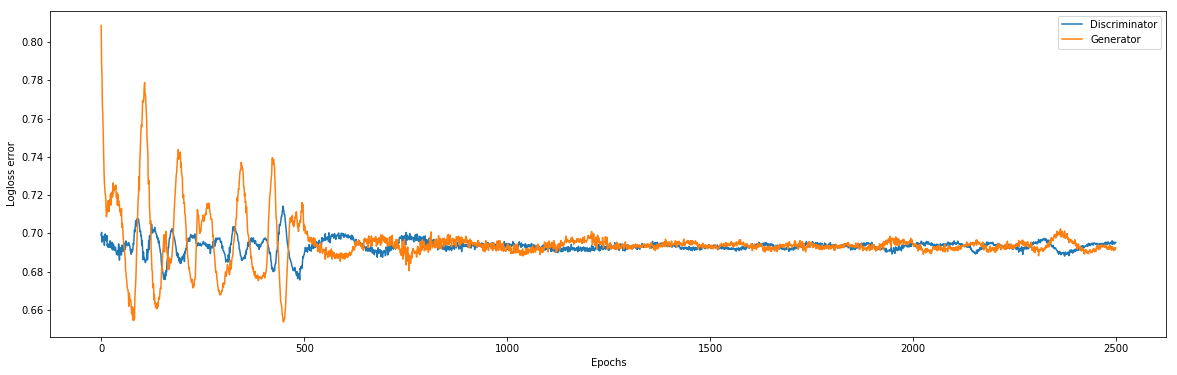

In [107]:
#graph comparison
fig,ax = plt.subplots(figsize = (20,6))
ax.plot(d_errors, label = "Discriminator")
ax.plot(g_errors, label = "Generator")
ax.set_xlabel('Epochs')
ax.set_ylabel('Logloss error')
ax.legend()
plt.show()

In [108]:
def comparedata(pp):
    pp = [list(np.array(x)) for x in pp]
    pp = torch.tensor(pp)
    pp = np.array(pp.detach().cpu())
    plt.scatter(pp[:,0],pp[:,1])
    
    #gen data
    b = np.array(gen(noise(DATASET)).detach().cpu())
    
    #compare
    plt.scatter(b[:,0],b[:,1])
    plt.show()

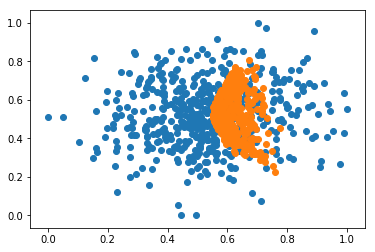

In [112]:
pp = []
for i in range(DATASET):
    pp.append(torch.load('data/'+ str(i+1) + '.pt'))
comparedata(pp)

In [161]:
torch.save(disc.state_dict(),'models/model3/disc.pt')
torch.save(gen.state_dict(),'models/model3/gen.pt')